In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as p
import plotly.express as px
import seaborn as sns
import scipy as sp
from scipy.stats import ttest_1samp, ttest_ind, ttest_rel, f_oneway
import scipy.stats as ss

 # **Background Supermarket**

1. Supermarket Store has launched 6 campaigns over the last two years. They have recorded the customers' data based on their demography (education and year birth) and customers' total money spent in USD over 6 product sales.
2. Target stakeholder: Marketing Team of Supermarket

3. Influence of discount on purchasing behaviour

4. Influence of place of purchases: catalog, web and store

assumption, when the sales is up, the income and revenue in the supermarket store will also go up (directly proportional)



# **Load Dataset**

In [72]:
df = pd.read_csv('Supermarket Customers.csv', sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# **Cleaning,change column's name and add necessary columns for analysis**

**See if there is null or missing row in every column**

In [73]:
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

**There is  24 missing rows in Income column, so i will input the median of the income for every education, so it will make it more valid for all the missing columns**

In [74]:
# see the education of every missing columns in income
df[df['Income'].isnull()][['Income', 'Education']]

,Income,Education
10,NaN,Graduation
27,NaN,Graduation
43,NaN,PhD
48,NaN,Graduation
58,NaN,Graduation
71,NaN,2n Cycle
90,NaN,PhD
91,NaN,Graduation
92,NaN,Master
128,NaN,PhD


**Median per education**

In [75]:
#median per education.
df[['Income', 'Education']].groupby('Education').median()

,Income
Education,
2n Cycle,46805.0
Basic,20744.0
Graduation,52028.5
Master,50943.0
PhD,55212.0


In [76]:
#input the missing columns with the median based on their education
df['Income'] = df.groupby('Education')['Income'].transform(lambda x: x.fillna(x.median()))
df['Income'].isnull().sum() #double check the missing columns, it is now 0 after being filled with the median based on the education


0

 **Response in the columns means the last campaign, so i will rename it**

In [77]:
df.rename(columns={'Response': 'Last_Campaign'}, inplace=True)


**change the dtype of Dt_Customer into datetime for knowing the first and last purchase in order to know the period of the purchases.**

In [78]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

first_purchase = df['Dt_Customer'].min()
last_purchase = df['Dt_Customer'].max()
print(f'first dan last purchase = {first_purchase} dan {last_purchase}') #Now we know that the data is from July 2012 - June 2014.


first dan last purchase = 2012-07-30 00:00:00 dan 2014-06-29 00:00:00


**add new columns named campaign_participation that sum all the six campaigns to know the participation rate of the customers**

In [79]:
#Make new column of total participation campaign

df['campaign_participation'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Last_Campaign']
df['campaign_participation'].value_counts() # This shows that there is no single customer that joins all the campaigns, the maximum is 5 campaigns with only 10 customers

campaign_participation
0    1631
1     370
2     142
3      51
4      36
5      10
Name: count, dtype: int64

**Classified the generation (making a new column) based on the year birth.**

In [80]:
def year_to_gen(year):
    if 0<= year <= 1945:
        return 'Silent'
    elif 1946 <= year <= 1964:
        return 'Boomers'
    elif 1965 <= year <= 1980:
        return 'Gen X'
    elif 1981 <= year <= 1996:
        return 'Millennials'
    elif 1997 <= year <= 2012:
        return 'Gen Z'
    

Generation = df['Year_Birth'].apply(year_to_gen)

df.insert(loc=2, column='Generation', value=Generation)

In [81]:
df['Generation'].value_counts()

Generation
Gen X          1069
Boomers         759
Millennials     385
Silent           27
Name: count, dtype: int64

**Add new columns named Total_Kids that combines the Teenhome and kidhome for knowing how many people the customers are living with**

In [82]:
df['Total_kids'] = df['Teenhome'] + df['Kidhome']
df['Total_kids'].value_counts()

Total_kids
1    1128
0     638
2     421
3      53
Name: count, dtype: int64

# **Check overview data**

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      2240 non-null   int64         
 1   Year_Birth              2240 non-null   int64         
 2   Generation              2240 non-null   object        
 3   Education               2240 non-null   object        
 4   Marital_Status          2240 non-null   object        
 5   Income                  2240 non-null   float64       
 6   Kidhome                 2240 non-null   int64         
 7   Teenhome                2240 non-null   int64         
 8   Dt_Customer             2240 non-null   datetime64[ns]
 9   Recency                 2240 non-null   int64         
 10  MntWines                2240 non-null   int64         
 11  MntFruits               2240 non-null   int64         
 12  MntMeatProducts         2240 non-null   int64   

In [84]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Last_Campaign,campaign_participation,Total_kids
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000,2240.000000,2240.000000
mean,5592.159821,1968.805804,52242.594866,0.444196,0.506250,2013-07-10 10:01:42.857142784,49.109375,303.935714,26.302232,166.950000,...,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107,0.446875,0.950446
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,2012-07-30 00:00:00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,0.000000,0.000000
25%,2828.250000,1959.000000,35538.750000,0.000000,0.000000,2013-01-16 00:00:00,24.000000,23.750000,1.000000,16.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,0.000000,0.000000
50%,5458.500000,1970.000000,51498.500000,0.000000,0.000000,2013-07-08 12:00:00,49.000000,173.500000,8.000000,67.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,0.000000,1.000000
75%,8427.750000,1977.000000,68289.750000,1.000000,1.000000,2013-12-30 06:00:00,74.000000,504.250000,33.000000,232.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,1.000000,1.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,2014-06-29 00:00:00,99.000000,1493.000000,199.000000,1725.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000,5.000000,3.000000
std,3246.662198,11.984069,25039.061738,0.538398,0.544538,NaN,28.962453,336.597393,39.773434,225.715373,...,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274,0.890543,0.751803


# **Marital Status of Customers**

**Dictionary about Marital Status**


Married: The individual is currently married.

Together: The individual is in a committed relationship, possibly cohabitating, but not legally married.

Single: The individual is not currently in a committed relationship or married.

Divorced: The individual was previously married but is now legally divorced.

Widow: The individual's spouse has passed away, and they have not remarried (this is gender-neutral; it could be used for either a man or a woman).

Alone: This could possibly mean that the individual prefers to be alone, i.e., they are not in a relationship and do not wish to be in one. 

Absurd: This is not a standard category and it's unclear what it might represent in this context. It may be a placeholder for invalid or nonsensical responses.

YOLO: This stands for "You Only Live Once". It's often used to express the idea that one should make the most of the present moment without worrying too much about the future. As a marital status, it is unclear what this might represent. It could potentially mean that the individual is not interested in being in a committed relationship or does not believe in the concept of marital statuses.


**Actually im going to combine absurd, yolo, and alone into 'single' because it simply means the same as we divide marital status simply just to know whether they are living with theirselves or with their families.**

In [85]:
df['Marital_Status'].value_counts()

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

In [86]:
#combining absurd, yolo and alone into single to make it simpler for the analysis 
#in analyzing the supermarket store, we only want to know whether they are living alone or with someone.

df['Marital_Status'] = df['Marital_Status'].replace(['YOLO', 'Absurd', 'Alone'], 'Single')
df['Marital_Status'].value_counts() #new value counts of marital status

Marital_Status
Married     864
Together    580
Single      487
Divorced    232
Widow        77
Name: count, dtype: int64

**Visualize it into pie chart, to know more about the majority of marital status**

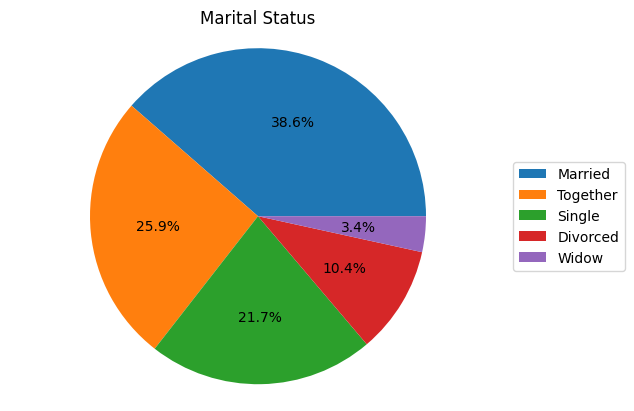

In [87]:
plt.pie(df['Marital_Status'].value_counts(), autopct='%1.1f%%')

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Create legend with labels outside
plt.legend(loc="center left", labels=df['Marital_Status'].value_counts().index, bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Marital Status')

plt.show()
#From the data we can know that the majority of the customers are living together or married.

**From the pie chart above, most of the customers are either living together or married. So it will probably be necessary to make segmented campaigns for those who have already had kids.**

# **Qualification (Education) of the customers**

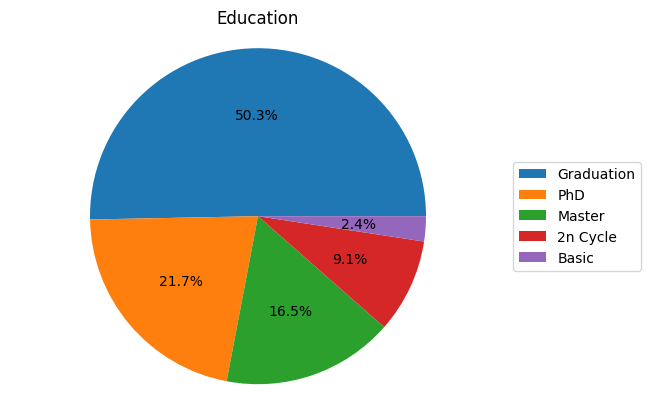

In [88]:
plt.pie(df['Education'].value_counts(), autopct='%1.1f%%')

plt.axis('equal')  # so make it a whole circle

# Create legend for labels outside
plt.legend(loc="center left", labels=df['Education'].value_counts().index, bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Education')

plt.show()


# **Generation of the customers in the supermarket store**

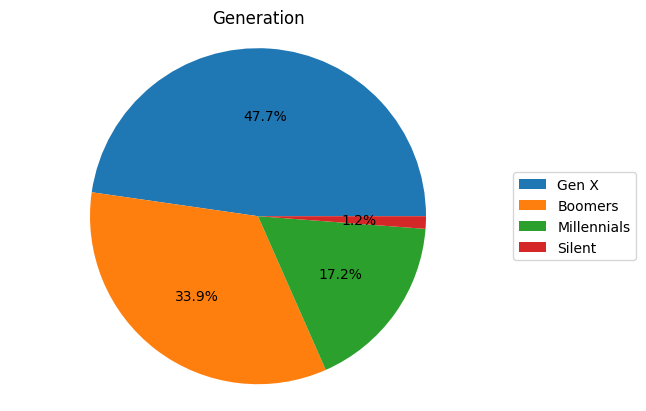

In [89]:
plt.pie(df['Generation'].value_counts(), autopct='%1.1f%%')

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Create legend with labels outside
plt.legend(loc="center left", labels=df['Generation'].value_counts().index, bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Generation')

plt.show()

**Most of the customers are either in Gen X (year birth between 1965 - 1980) or Boomers (year birth between 1946 - 1964)**

# **Supermarket Store service, measured by total complains**

Complain
0    2219
1      21
Name: count, dtype: int64

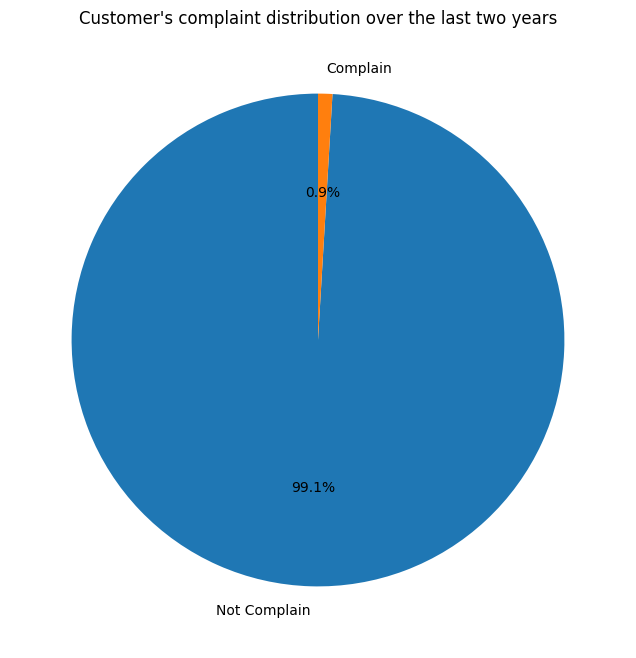

In [90]:
display(df['Complain'].value_counts())

complain_counts = df['Complain'].value_counts().rename({0: 'Not Complain', 1: 'Complain'})

# Create the pie chart
plt.figure(figsize=(10, 8))
plt.pie(complain_counts, labels=complain_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Customer's complaint distribution over the last two years")
plt.show()


**Find out the 21 customers' background, to know why they are complaining and can find a solution to increase the services**

**from the data, it is known that the supermarket's services is satisfied as only 0.9% of total customers who complained**

In [91]:
df[df['Complain'] == 1][['Complain','Generation','Education']].value_counts()



Complain  Generation   Education 
1         Boomers      Graduation    9
          Gen X        Graduation    4
          Millennials  2n Cycle      2
          Gen X        2n Cycle      1
          Millennials  Graduation    1
                       Master        1
                       PhD           1
          Silent       2n Cycle      1
                       Master        1
Name: count, dtype: int64

**This shows that Booomers and Graduation (demographically) are the most ones who complained, which is 9/21 =  42.857%.**

**The supermarket's owner should give them some questionnaire regarding their services, and state their complains, so that the supermarket's service will increase to 100%**

**Visualize Total_Kids to know the proportion of total kids the customers have**

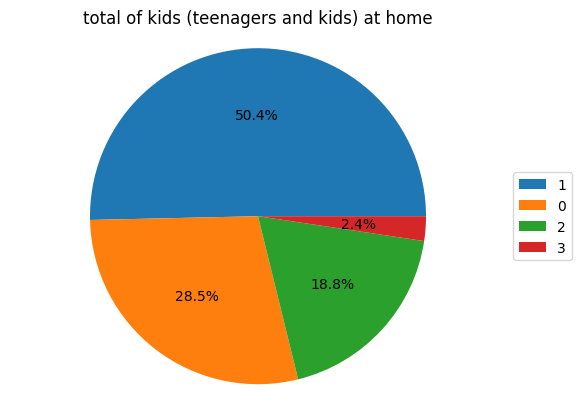

In [92]:
plt.pie(df['Total_kids'].value_counts(), autopct='%1.1f%%')

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Create legend with labels outside
plt.legend(loc="center left", labels=df['Total_kids'].value_counts().index, bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("total of kids (teenagers and kids) at home")
plt.show()


**From the pie chart, we can see that most of the customers (50.4%) have 1 kid and only 18.8% customers who don't have any kids.**

**This is matched by the analysis before regarding the customers' marital status**

# **ANALYSIS DATA**

**Connection between total kids and total campaign participation**

The formula is (*6) because there is a total of 6 campaigns.

In [93]:
df['campaign_participation'].groupby(df['Total_kids']).sum() / df['Total_kids'].value_counts()*6


Total_kids
0    5.191223
1    1.792553
2    1.453682
3    1.132075
dtype: float64

**This could be a recommendation for the marketing team to create segmented campaign for marriage ones especially for those who have kids because the percentage of campaign participation for those who have kids (1-3) is still very low, roughly below 2% and only 18.8% of total customers who don't have kids.**

# **Products Analysis**
Product Analysis: Which products are the best-sellers? Which ones are not performing well? You could also analyze which products are often purchased together (basket analysis) to gain insights for promotional offers or placement strategies.

Products:

● MntWines: Amount spent on wine in last 2 years

● MntFruits: Amount spent on fruits in last 2 years

● MntMeatProducts: Amount spent on meat in last 2 years

● MntFishProducts: Amount spent on fish in last 2 years

● MntSweetProducts: Amount spent on sweets in last 2 years

● MntGoldProds: Amount spent on gold in last 2 years

**This is measured by the total amount in USD spent because there is no total quantity sold in the dataset**

**Proportion of total amount in USD of all items available in the store** 

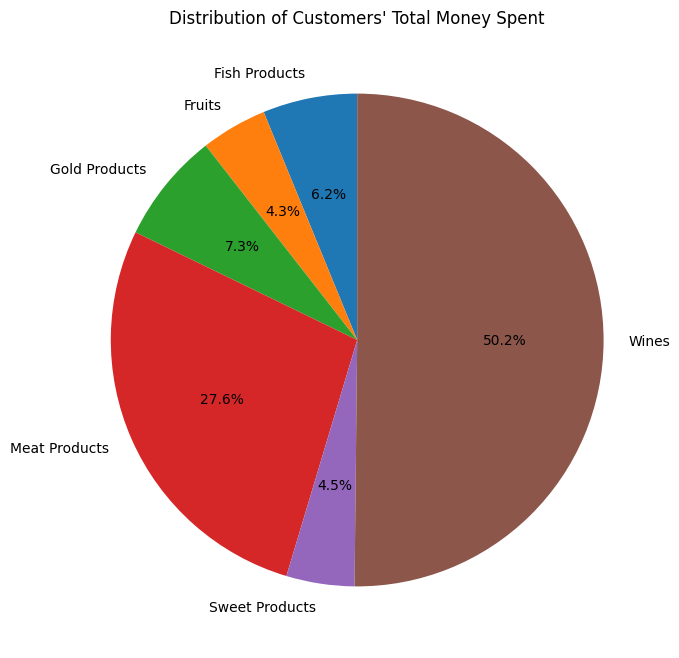

Fish Products      84057
Fruits             58917
Gold Products      98609
Meat Products     373968
Sweet Products     60621
Wines             680816
dtype: int64

In [94]:
#calculate total customer's spending based on each product over the last two years.

# Calculate the total amount spent on each category
sums = {
    'Fish Products': df['MntFishProducts'].sum(),
    'Fruits': df['MntFruits'].sum(),
    'Gold Products': df['MntGoldProds'].sum(),
    'Meat Products': df['MntMeatProducts'].sum(),
    'Sweet Products': df['MntSweetProducts'].sum(),
    'Wines': df['MntWines'].sum()
}

# Convert dictionary to Series for easier plotting
sum_series = pd.Series(sums)

# Create the pie chart --> GANTI JADI BAR CHART. (ANALISA JUMLAH USD NYA)
plt.figure(figsize=(10, 8))
plt.pie(sum_series, labels=sum_series.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Customers' Total Money Spent")
plt.show()

display(sum_series)




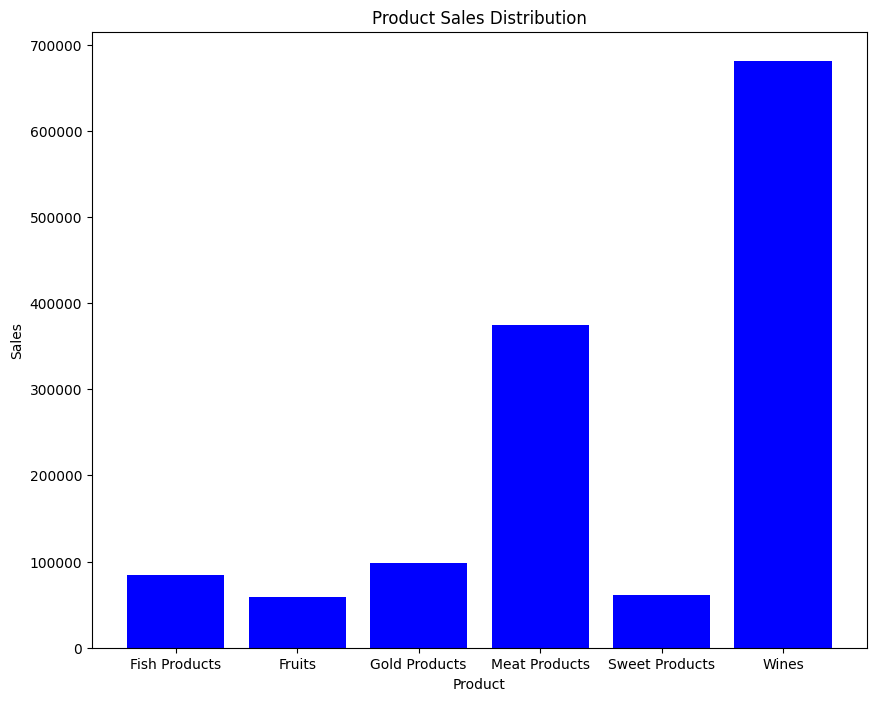

In [95]:
plt.figure(figsize=(10, 8))
plt.bar(sum_series.index, sum_series, color='blue')
plt.title('Product Sales Distribution')
plt.xlabel('Product')
plt.ylabel('Sales')
plt.show()


**This is necessary to visualize the product sales distribution(in USD) to know which products impact the most in revenue and income with assumption of increase of sales results increase of income and revenue of the supermarket store.**

# **The Influence of Promotion on purchases made by customer over the last two years**


● NumDealsPurchases: Number of purchases made with a discount

● AcceptedCmp1: 1 if the customer accepted the offer in the 1st campaign, 0 otherwise

● AcceptedCmp2: 1 if the customer accepted the offer in the 2nd campaign, 0 otherwise

● AcceptedCmp3: 1 if the customer accepted the offer in the 3rd campaign, 0 otherwise

● AcceptedCmp4: 1 if the customer accepted the offer in the 4th campaign, 0 otherwise

● AcceptedCmp5: 1 if the customer accepted the offer in the 5th campaign, 0 otherwise

● Response: 1 if the customer accepted the offer in the last campaign, 0 otherwise (Last Campaign)

NumDealsPurchases
0      46
1     970
2     497
3     297
4     189
5      94
6      61
7      40
8      14
9       8
10      5
11      5
12      4
13      3
15      7
Name: count, dtype: int64

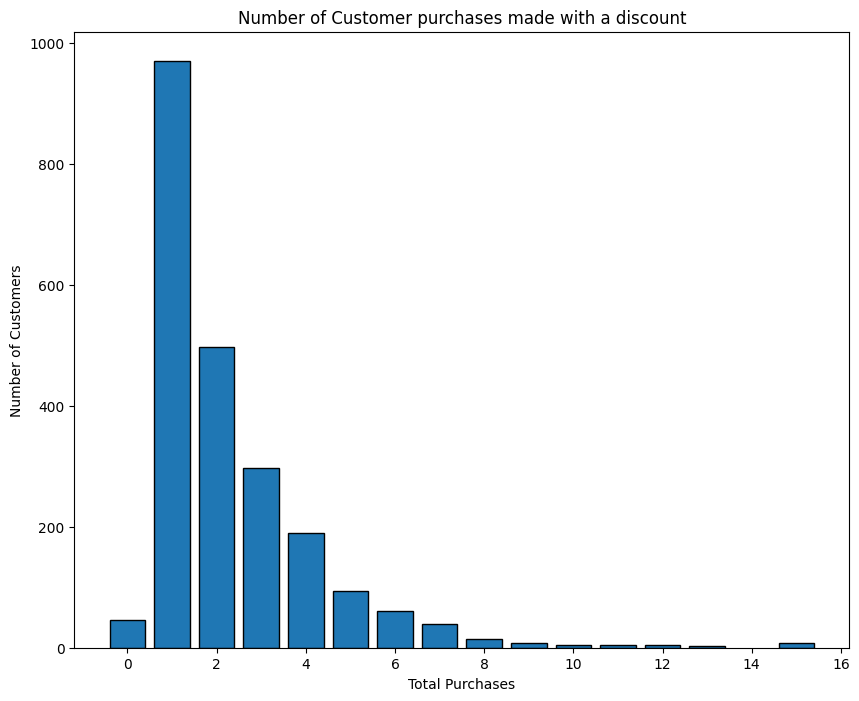

In [96]:

# First, get the counts for each unique value in the 'NumDealsPurchases' column
deal_counts = df['NumDealsPurchases'].value_counts()

# Sort by index for a more meaningful chart (remove this line if you want to sort by values instead)
deal_counts = deal_counts.sort_index()
display(deal_counts)
# Create the bar chart
plt.figure(figsize=(10, 8))
plt.bar(deal_counts.index, deal_counts.values, edgecolor='black')
plt.title("Number of Customer purchases made with a discount")
plt.xlabel('Total Purchases')
plt.ylabel('Number of Customers')
plt.show()

**The data above shows that only 46 of 2240 customers who didn't purchase items with discount, which means 2196/2240 customers purchase items with discount, accumulated to 97.946% customers purchasing items with discount**

**This shows that discount on items should be maintained as discounts are really impactful towards customers' purchasing behaviour**


# **Information of percentage customers involved in every campaign**




In [97]:
#Percentage of accepted of 5 campaign (to check its marketing)
Percentage1 = f"{len(df[df['AcceptedCmp1'] == 1]) / len(df) * 100:.2f}%"
Percentage2 = f"{len(df[df['AcceptedCmp2'] == 1]) / len(df) * 100:.2f}%"
Percentage3 = f"{len(df[df['AcceptedCmp3'] == 1]) / len(df) * 100:.2f}%"
Percentage4 = f"{len(df[df['AcceptedCmp4'] == 1]) / len(df) * 100:.2f}%"
Percentage5 = f"{len(df[df['AcceptedCmp5'] == 1]) / len(df) * 100:.2f}%"
Percentage6 = f"{len(df[df['Last_Campaign'] == 1]) / len(df) * 100:.2f}%"

print('Success Rate over 6 campaigns, which is determined when the customer accepted the offer')
print(f'''
1st campaign = {Percentage1}
2nd campaign = {Percentage2}
3rd campaign = {Percentage3}
4th campaign = {Percentage4}
5th campaign = {Percentage5}
last campaign = {Percentage6}''')

Success Rate over 6 campaigns, which is determined when the customer accepted the offer

1st campaign = 6.43%
2nd campaign = 1.34%
3rd campaign = 7.28%
4th campaign = 7.46%
5th campaign = 7.28%
last campaign = 14.91%


# **Purchases based on place**

● NumWebPurchases: Number of purchases made through the company’s website

● NumCatalogPurchases: Number of purchases made using a catalog

● NumStorePurchases: Number of purchases made directly in stores

In [98]:
display(df['NumWebPurchases'].value_counts().sort_index())
display(df['NumCatalogPurchases'].value_counts().sort_index())
display(df['NumStorePurchases'].value_counts().sort_index())
display(df['NumWebVisitsMonth'].value_counts().sort_index())


Catalog_Not_Purchase = f"{len(df[df['NumCatalogPurchases'] == 0]) / len(df) * 100:.2f}%"
print(f'Percentage of customer did not purchase any items from catalog purchases: {Catalog_Not_Purchase}')
#data shows that catalog purchases has the most 0 purchases compared to the other, which are 586 of the total customers, accumulate = 26.16%
#this shows that marketing via catalog is the most inefficient compared to web or store purchases.


Web_Not_Purchase = f"{len(df[df['NumWebPurchases'] == 0]) / len(df) * 100:.2f}%"
print(f'Percentage of customer did not purchase any items from web purchases: {Web_Not_Purchase}')


Store_Not_Purchase = f"{len(df[df['NumStorePurchases'] == 0]) / len(df) * 100:.2f}%"
print(f'Percentage of customer did not purchase any items from store purchases: {Store_Not_Purchase}')

NumWebPurchases
0      49
1     354
2     373
3     336
4     280
5     220
6     205
7     155
8     102
9      75
10     43
11     44
23      1
25      1
27      2
Name: count, dtype: int64

NumCatalogPurchases
0     586
1     497
2     276
3     184
4     182
5     140
6     128
7      79
8      55
9      42
10     48
11     19
22      1
28      3
Name: count, dtype: int64

NumStorePurchases
0      15
1       7
2     223
3     490
4     323
5     212
6     178
7     143
8     149
9     106
10    125
11     81
12    105
13     83
Name: count, dtype: int64

NumWebVisitsMonth
0      11
1     153
2     202
3     205
4     218
5     281
6     340
7     393
8     342
9      83
10      3
13      1
14      2
17      1
19      2
20      3
Name: count, dtype: int64

Percentage of customer did not purchase any items from catalog purchases: 26.16%
Percentage of customer did not purchase any items from web purchases: 2.19%
Percentage of customer did not purchase any items from store purchases: 0.67%


**Data above shows that the most impactful place of purchases are store and web purchases as 26.16% customers didn't purchase items from catalog purchases**

**Find out the percentage of every generation who participate in every campaign**

the formula is again (*^6) as the total value of campaign participation is 6, so 100% for each customer means that the customer joins all the six campaigns. 

In [99]:
df_grouped = df.groupby('Generation')['campaign_participation'].sum() / df.groupby('Generation')['campaign_participation'].count() * 6
print(df_grouped)


Generation
Boomers        2.727273
Gen X          2.312442
Millennials    3.522078
Silent         4.000000
Name: campaign_participation, dtype: float64


**Data above shows that the silent generation participated the most amongst the others, accumulated total of 4%**

**Find out the percentage of every education who participate in every campaign**

the formula is again (*^6) as the total value of campaign participation is 6, so 100% for each customer means that the customer joins all the six campaigns. 

In [100]:
df_grouped_ed = df.groupby('Education')['campaign_participation'].sum() / df.groupby('Education')['campaign_participation'].count() * 6
print(df_grouped_ed)


Education
2n Cycle      2.157635
Basic         0.888889
Graduation    2.635315
Master        2.594595
PhD           3.271605
Name: campaign_participation, dtype: float64


**Data above shows that those customers with PhD degree participated the most amongst the others, accumulated total of 3.271%**

**Effectiveness of online website to gather customer's interest in buying items in the supermarket store.** 

● NumWebVisitsMonth: Number of visits to the company’s website in the last month

In [101]:
display(df['NumWebVisitsMonth'].value_counts())


Web_Not_Visit = f"{len(df[df['NumWebVisitsMonth'] == 0]) / len(df) * 100:.2f}%"
print(f"Percentage of customer did not visit the company's website over the last month: {Web_Not_Visit}")



NumWebVisitsMonth
7     393
8     342
6     340
5     281
4     218
3     205
2     202
1     153
9      83
0      11
20      3
10      3
14      2
19      2
17      1
13      1
Name: count, dtype: int64

Percentage of customer did not visit the company's website over the last month: 0.49%


**This shows that only 0.49% accumulated of the total customers who did not visit the company's website. --> shows that the company's website assumed to be helpful in promoting the products in the supermarket store.**

# **Conclusion:**

1. In terms of the demography, most of the customers are Gen X (with a year birth of 1965-1980) and their education are mostly graduation.
2. Supermarket's six campaigns does not really engage the customers as only in the 1st to 5th campaign, the customers' participation are below 10%.
3. Supermarket's services is outstanding as only 0.9% of total customers complained.
4. Discounts really impacts customers purchasing behaviour.
5. Supermarket's web is effective in promoting their items as most of the customers visit the web.

# **Recommendation:**

1. From the Analysis, in terms of marital status, most of the customers are living together or married, it is recommended for the marketing team to make segmented campaigns for married ones (for their family), within this, it is hoped that those married / living together will be interested and involved in the campaigns.

2. same as the above, those who have kids (1-3 kids), only participates around 1-2%, it is recommended to make segmented campaigns especially for those who have kids.

3. From the complain analysis, only 21 customers of 2240 who complained, which means 99.1% customers didn't complain, this means that the supermaket service is already satistfying enough and should be maintainted. It is also recommended that the supermarket owner should give questionnaire for those 21 customers about their complains, to increase the service to 100% satisfying for the customers.

4. in terms of the product sales distribution in USD, with the assumption of increase sales will increase income and revenue, the supermarket marketing team should focus on selling wines (accumulated to 50.2%) and meat products (accumulated to 27.6%) of total sales distribution as both are the items with the most impact towards the sales distribution.

5. In terms of discount, the supermarket team should still maintain discount as 97.946% customers purchase items with discount.

6. In terms of place of purchase, the supermarket team should focus on web purchases instead of catalog purchases as only 2.19% customers didn't buy from web compared to catalog which accumulates 26.16% customers who didn't purchase from catalog purchases. The most effective ones are still store purchases. The customers are also interested in the supermarket's web, as only 11 or 0.49% of total customers who didn't visit the web during the last month, so it is recommended that the web should be maintained.

**Save the final file that has been analyzed for visualization in tableau**

In [102]:
df.to_csv('supermarket_cleaning.csv', index=False)